# MGMGT 638-001 Assignment 1 
## Part 1: Moving Averages Strategy
Choose a stock and backtest a moving average strategy.  Evaluate the strategy relative to buy and hold based on mean return and Sharpe ratio.

Author: Francho Garcia Takis <br>
Date: 06-11-2024

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
from pandas_datareader import DataReader as pdr

np.random.seed(6112024)

### Selecting the Stock

In [4]:
#The stock_data is used to generate a list of all stock tickers available on the NYSE, NASDAQ, and AMEX. 
#tickers_data = pd.read_csv('../data/stock_data.csv')
url = 'https://raw.githubusercontent.com/Franch-GT/DataDrivenInvestments/refs/heads/main/Assignment_1/data/stock_data.csv'
tickers_data = pd.read_csv(url)
all_tickers = list(tickers_data['Symbol'].unique())

In [5]:
def get_stock_data(ticker=None):
    """
    Gets the adjusted closing price data for a random stock (if left unspecified)
    or the adj. closing price of the specified stock for the period that is available.
    """
    if ticker is None:
        ticker = np.random.choice(all_tickers) # get a random stock from the tickers list
        print(f"Getting data for stock {ticker}")

    #Get the Adj Close data for the stock
    data = yf.download(ticker)['Adj Close']
    data.index = pd.to_datetime(data.index.strftime('%Y-%m-%d'))
    data = pd.DataFrame(data)
    data.columns = ['Close'] # rename for ease of use

    return data, ticker

In [6]:
data, name = get_stock_data()

Getting data for stock SYBT


[*********************100%***********************]  1 of 1 completed


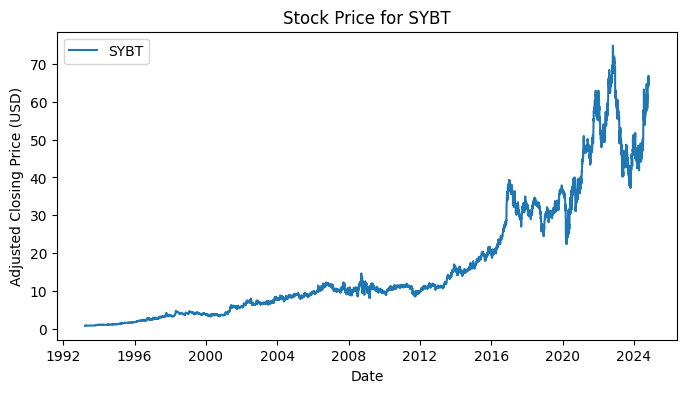

In [7]:
plt.figure(figsize=(8, 4)) 
plt.plot(data, label=name)
plt.title(f'Stock Price for {name}')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend()

plt.show()

### Creating the Moving Averages

In [8]:
#Creating different moving averages to compare: 
data['five_MA'] = data['Close'].rolling(window=5).mean() # 5-day moving average
data['ten_MA'] = data['Close'].rolling(window=10).mean() # 10-day 
data['twenty_MA'] = data['Close'].rolling(window=20).mean() # 20-day

#Creating the 50 day moving average to use as the signal for the strategy
data['fifty_MA'] = data['Close'].rolling(window=50).mean() 

data['five_MA'] = data.five_MA.shift() # Lagging the MA by one day to avoid data leakage
data['ten_MA'] = data.ten_MA.shift()
data['twenty_MA'] = data.twenty_MA.shift()
data['fifty_MA'] = data.fifty_MA.shift()

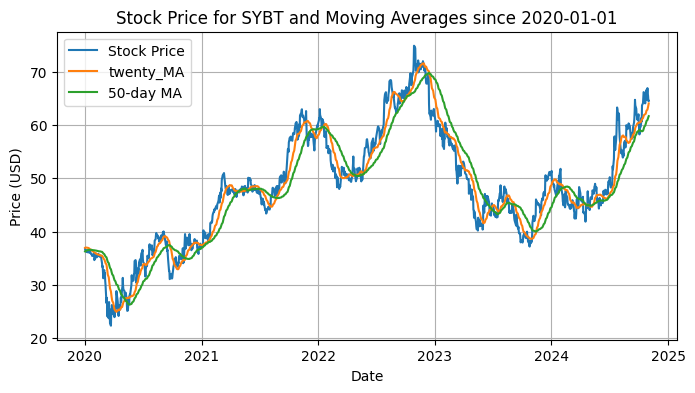

In [9]:
#Graphing the stock price and moving averages 
start_date = pd.Timestamp('2020-01-01') if (
    data.index[0] < pd.Timestamp('2020-01-01') ) else (
         data.index[0]) #Selecting a start date for the graph

selected_MA = 'twenty_MA' # select a specific MA to avoid cluttering the graph with too many

plt.figure(figsize=(8, 4))
plt.plot(data['Close'][start_date:], label='Stock Price')
plt.plot(data[selected_MA][start_date:], label=selected_MA)
plt.plot(data['fifty_MA'][start_date:], label='50-day MA')
plt.title(f'Stock Price for {name} and Moving Averages since {start_date.date()}')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid()

plt.show()

### Computing Returns for the Strategy

In [10]:
# Compute the % change in closing price from previous day: 
data['buy_hold'] = data.Close.pct_change() 

# Calculate whether each day would be buy or not according to each MA strategy:
data['long_five'] = data.five_MA > data.fifty_MA # Buy (True) if 5-day MA > 50-day MA
data['long_ten'] = data.ten_MA > data.fifty_MA 
data['long_twenty'] = data.twenty_MA > data.fifty_MA

# Determine the returns for each day for each strategy:
data['returns_five'] = data.long_five * data.buy_hold 
data['returns_ten'] = data.long_ten * data.buy_hold
data['returns_twenty'] = data.long_twenty * data.buy_hold

data = data.dropna().round(3) # Drop the NA vals and round to 3 decimal places

### Evaluating Moving Strategy Returns & Sharpe Ratio

In [11]:
#Determining the returns from just buying and holding: 
buy_hold = 252*data.buy_hold.mean() 

# Calculating the returns from each MA strategy:
returns_five_MA = 252*data.returns_five.mean()
returns_ten_MA = 252*data.returns_ten.mean()
returns_twenty_MA = 252*data.returns_twenty.mean()

print(f"Returns from buying and holding: {buy_hold:.2%}% annualised")
print(f"Returns from 5-day MA strategy: {returns_five_MA:.2%}% annualised")
print(f"Returns from 10-day MA strategy: {returns_ten_MA:.2%}% annualised")
print(f"Returns from 20-day MA strategy: {returns_twenty_MA:.2%}% annualised")

Returns from buying and holding: 19.69%% annualised
Returns from 5-day MA strategy: 5.45%% annualised
Returns from 10-day MA strategy: 11.17%% annualised
Returns from 20-day MA strategy: 10.65%% annualised


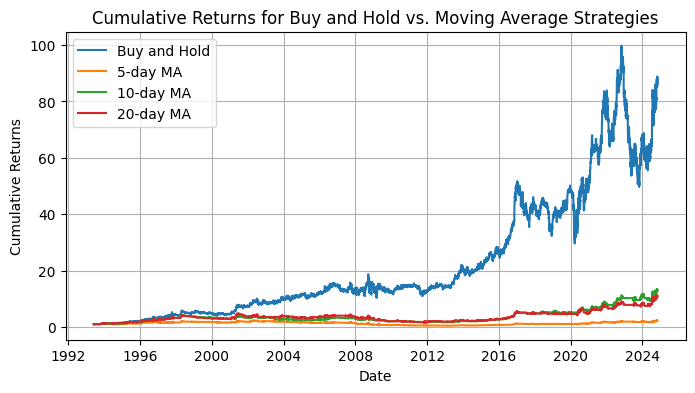

In [12]:
#Plotting the compound returns for each strategy
cumulative_returns_df = pd.DataFrame({
    'Buy and Hold': (1 + data.buy_hold).cumprod(),
    '5-day MA': (1 + data.returns_five).cumprod(),
    '10-day MA': (1 + data.returns_ten).cumprod(),
    '20-day MA': (1 + data.returns_twenty).cumprod()
})

#Select the start date:
start_date = data.index[0]
'''
start_date = pd.Timestamp('2020-01-01') if (
    data.index[0] < pd.Timestamp('2020-01-01') ) else (
         data.index[0]) 
'''

plt.figure(figsize=(8, 4))
plt.plot(cumulative_returns_df[start_date:], label=cumulative_returns_df.columns)
plt.title('Cumulative Returns for Buy and Hold vs. Moving Average Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()

plt.show()

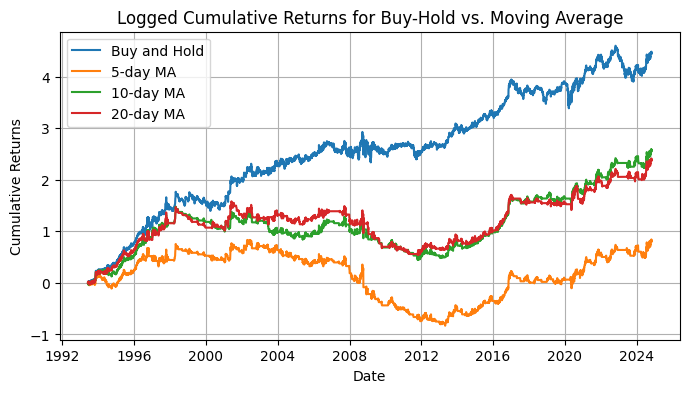

In [13]:
log_cumulative_returns_df = np.log(cumulative_returns_df) # log the returns

plt.figure(figsize=(8, 4))
plt.plot(log_cumulative_returns_df[start_date:], label=log_cumulative_returns_df.columns)
plt.title('Logged Cumulative Returns for Buy-Hold vs. Moving Average')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()

plt.show()

In [14]:
cumulative_returns_df.tail(1)

,Buy and Hold,5-day MA,10-day MA,20-day MA
Date,,,,
2024-11-01,85.592194,2.234656,12.885904,10.760053


In [15]:
# Sharpe Ratios:
rf_rate = 0.0397 
sharpe_buy_hold = (
    (252*data.buy_hold.mean() - rf_rate) / (np.sqrt(252)*data.buy_hold.std())
)
sharpe_five_MA = (
    (252*data.returns_five.mean() - rf_rate) / (np.sqrt(252)*data.returns_five.std())
)
sharpe_ten_MA = (
    (252*data.returns_ten.mean() - rf_rate) / (np.sqrt(252)*data.returns_ten.std())
)
sharpe_twenty_MA = (
    (252*data.returns_twenty.mean() - rf_rate) / (np.sqrt(252)*data.returns_twenty.std())
)

print(f"Sharpe Ratio for Buy and Hold: {sharpe_buy_hold:.2%} annualised")
print(f"Sharpe Ratio for 5-day MA strategy: {sharpe_five_MA:.2%} annualised")
print(f"Sharpe Ratio for 10-day MA strategy: {sharpe_ten_MA:.2%} annualised")
print(f"Sharpe Ratio for 20-day MA strategy: {sharpe_twenty_MA:.2%} annualised")

Sharpe Ratio for Buy and Hold: 47.21% annualised
Sharpe Ratio for 5-day MA strategy: 6.17% annualised
Sharpe Ratio for 10-day MA strategy: 29.20% annualised
Sharpe Ratio for 20-day MA strategy: 26.85% annualised


### Observations
- Usually the buy and hold strategy tends to outperform a moving average strategy of any window size both in terms of annualised returns and sharpe ratio. 
- However, sometimes, like in the case of 'CVE' the moving average strategy can have higher compounded returns when a stock experiences a large sudden drop in price. The buy and hold strategy bears the drop, whilst the moving average strategy exits the position and only re-enters when the trend is reversed.  